In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import sys
import json
import os
sys.path.append('../')
import config

In [99]:
# Define Transformer Encoder
# Define Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.5):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout layer
    
    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        x = self.dropout(x)  # Apply dropout
        return x

In [100]:
# Define Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, dropout_rate=0.5):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout layer
    
    def forward(self, x):
        x = self.dropout(x)  # Apply dropout
        x = self.fc(x)
        return x

In [101]:
# # Define a custom dataset
# from torch.utils.data import Dataset, DataLoader
# # Define your dataset class
# class EmbeddingDataset(Dataset):
#     def __init__(self, text_embeddings, graph_embeddings):
#         self.text_embeddings = torch.tensor(text_embeddings, dtype=torch.float32)
#         self.graph_embeddings = torch.tensor(graph_embeddings, dtype=torch.float32)
    
#     def __len__(self):
#         return len(self.text_embeddings)
    
#     def __getitem__(self, idx):
#         text_embedding = self.text_embeddings[idx]
#         graph_embedding = self.graph_embeddings[idx]
#         return text_embedding, graph_embedding

In [102]:
import json
import numpy as np
total_obj=1136
paragraphs = []
with open(config.DESCRIPTION_FILE) as fp:
    id_to_desc = json.load(fp)
with open(config.DATA_DIR+"doc_id_to_emb_id.json") as fp:
    id_to_pos = json.load(fp)
with open(config.DATA_DIR+'emb_id_to_doc_id.json') as fp:
    pos_to_id = json.load(fp)
# print(id_to_desc.keys())
for key in id_to_desc:
    paragraphs.append(id_to_desc[key])
graph_embeddings = np.load(config.OUTPUT_DIR+"gcl_data/pt_gpt2-xl/sample_10/GAT/triplet/text_deepwalk_dual3_gm_1.0.npy")
text_embeddings = np.load(config.EMBEDDING_DIR+"pt_gpt2-xl/text_embeddings.npy")

In [103]:
graph_embeddings.shape

(1136, 128)

In [104]:
# Hyperparameters
text_embedding_dim = text_embeddings.shape[1]  # Example text embedding dimension
graph_embedding_dim = graph_embeddings.shape[1]  # Desired graph embedding dimension
hidden_dim = 128
lr = 0.001
batch_size = 64
shuffle = True
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
text_embeddings_tensor = torch.tensor(text_embeddings, dtype=torch.float32).to(device)
graph_embeddings_tensor = torch.tensor(graph_embeddings, dtype=torch.float32).to(device)

In [106]:
# Initialize Encoder and Decoder
encoder = Encoder(text_embedding_dim, hidden_dim).to(device)
decoder = Decoder(hidden_dim, graph_embedding_dim).to(device)


In [107]:
# Define loss function and optimizer
import torch.optim as optim
# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)


In [108]:
# Training the cGAN
epochs = 10000
# Training loop
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()
    
    # Forward pass
    encoded_text = encoder(text_embeddings_tensor.to(device))
    predicted_graph_embeddings = decoder(encoded_text)
    
    # Compute loss
    loss = criterion(predicted_graph_embeddings, graph_embeddings_tensor.to(device))
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 0.2082
Epoch [200/10000], Loss: 0.1887
Epoch [300/10000], Loss: 0.1770
Epoch [400/10000], Loss: 0.1750
Epoch [500/10000], Loss: 0.1715
Epoch [600/10000], Loss: 0.1684
Epoch [700/10000], Loss: 0.1643
Epoch [800/10000], Loss: 0.1703
Epoch [900/10000], Loss: 0.1645
Epoch [1000/10000], Loss: 0.1629
Epoch [1100/10000], Loss: 0.1630
Epoch [1200/10000], Loss: 0.1574
Epoch [1300/10000], Loss: 0.1617
Epoch [1400/10000], Loss: 0.1627
Epoch [1500/10000], Loss: 0.1604
Epoch [1600/10000], Loss: 0.1620
Epoch [1700/10000], Loss: 0.1556
Epoch [1800/10000], Loss: 0.1584
Epoch [1900/10000], Loss: 0.1639
Epoch [2000/10000], Loss: 0.1551
Epoch [2100/10000], Loss: 0.1590
Epoch [2200/10000], Loss: 0.1594
Epoch [2300/10000], Loss: 0.1586
Epoch [2400/10000], Loss: 0.1586
Epoch [2500/10000], Loss: 0.1622
Epoch [2600/10000], Loss: 0.1570
Epoch [2700/10000], Loss: 0.1578
Epoch [2800/10000], Loss: 0.1600
Epoch [2900/10000], Loss: 0.1587
Epoch [3000/10000], Loss: 0.1597
Epoch [3100/10000],

In [109]:
# Optionally, save the model
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, 'data/encoder_decoder_model.pth')

In [111]:
# Define the noise parameters
noise_stddev = 0.01  # Standard deviation of the noise
noise = np.random.normal(loc=0.0, scale=noise_stddev, size=graph_embeddings.shape)

# Add the noise to the original embeddings
noisy_embeddings = graph_embeddings + noise

In [112]:
# Load model state


In [113]:
# # Define the noise parameters
# noise_stddev = 0.3  # Standard deviation of the noise
# noise = np.random.normal(loc=0.0, scale=noise_stddev, size=text_embeddings.shape)

# # Add the noise to the original embeddings
# noisy_embeddings = text_embeddings + noise
# with open("data/noisy_text_embeddings.npy", 'wb') as f:
#     np.save(f,noisy_embeddings)

In [114]:
with open("data/noisy_text_embeddings.npy", 'rb') as f:
    noisy_embeddings = np.load(f)

In [115]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
def get_sim(gen_emb, org_emb):
    # Compute the cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(gen_emb, org_emb)
    diagonal_values = np.diagonal(cosine_sim_matrix)
    # print(cosine_sim_matrix.shape)  # Should print (203, 933)
    return diagonal_values

In [116]:
import numpy as np
import random
from matplotlib import pyplot as plt
def plot(sim_vec, title):
    plt.figure(figsize=(5, 5))
    plt.hist(sim_vec, bins=np.arange(0, 1.1, 0.05), edgecolor='black')  
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.savefig(title+".png", dpi=300, bbox_inches='tight')
    # Show plot
    plt.show()

In [117]:
sim_vec2 = get_sim(noisy_embeddings, text_embeddings)
sim_vec2

array([0.82619745, 0.79746806, 0.83329961, ..., 0.72012401, 0.79849182,
       0.80027154])

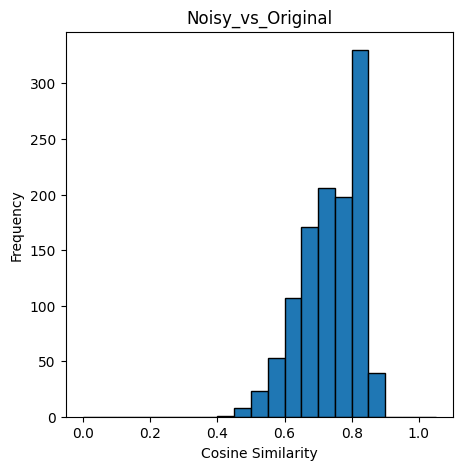

In [118]:
plot(sim_vec2, "Noisy_vs_Original")

In [119]:
def generate_graph_emb(org_emb):
    checkpoint = torch.load('data/encoder_decoder_model.pth')

    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    # Ensure the model is in evaluation mode
    encoder.eval()
    decoder.eval()
    
    # Load new text embeddings
    new_text_embeddings = org_emb
    new_text_embeddings = torch.tensor(new_text_embeddings, dtype=torch.float32).to(device)
    
    # Perform inference
    with torch.no_grad():
        # Pass new text embeddings through the encoder
        encoded_text = encoder(new_text_embeddings.to(device))
        
        # Generate graph embeddings through the decoder
        generated_graph_embeddings = decoder(encoded_text)
    
    # Convert the generated embeddings back to numpy if needed
    generated_graph_embeddings = generated_graph_embeddings.cpu().detach().numpy()
    
    print("Generated Graph Embeddings:", generated_graph_embeddings)
    return generated_graph_embeddings

In [120]:
graph1 = generate_graph_emb(text_embeddings)

Generated Graph Embeddings: [[-1.1740153  -1.01015    -0.2512905  ...  0.44133717  0.30949983
   0.36544123]
 [-0.904301   -0.64616984 -0.20639436 ...  0.42700005  0.04671192
   0.08459631]
 [-0.12834564 -0.31765145 -0.20970097 ...  0.4504913  -0.3257302
  -0.30576536]
 ...
 [-0.36722797 -0.50676835 -0.07316626 ...  0.60349524 -0.22161524
   0.22759426]
 [-0.1986418  -0.30490083 -0.06323767 ...  0.60967    -0.36579934
   0.19291902]
 [-0.10412661 -0.24673572 -0.24601439 ...  0.49786538 -0.3731614
   0.25640884]]


In [121]:
graph2 = generate_graph_emb(noisy_embeddings)

Generated Graph Embeddings: [[-1.6098409  -0.77176166 -0.1511937  ...  0.40001515  0.28427783
  -0.04850648]
 [-1.10754    -0.73625815 -0.2691872  ...  0.37819928  0.12898794
  -0.187076  ]
 [-0.45227736 -0.57459545 -0.4337079  ...  0.3535733  -0.10320413
  -0.3551753 ]
 ...
 [-0.16256587 -0.34173587  0.07178901 ...  0.7959479  -0.4565995
   0.3983268 ]
 [-0.11766743 -0.27440268  0.0443031  ...  0.664132   -0.33017093
   0.47863135]
 [ 0.05379157 -0.10474854 -0.12199724 ...  0.45727813 -0.41663435
   0.13110286]]


In [122]:
# with open("../../ics_cwe/Text_Hop/{}/data/Encoder_Decoder_generated.npy".format("pt_Gpt2"), 'wb') as f:
#     np.save(f,generated_graph_embeddings)

In [123]:
sim_vec1 = get_sim(graph1, graph_embeddings)

In [124]:
sim_vec2 = get_sim(graph2, graph_embeddings)

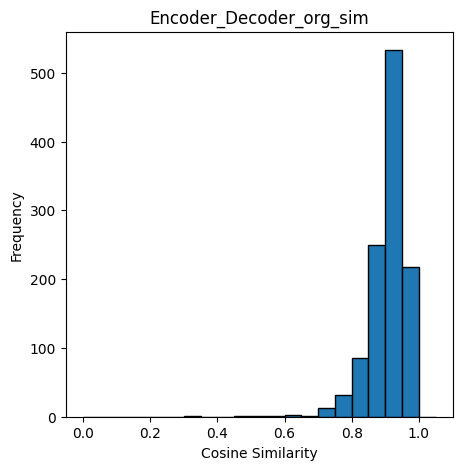

In [125]:
plot(sim_vec1, "Encoder_Decoder_org_sim")

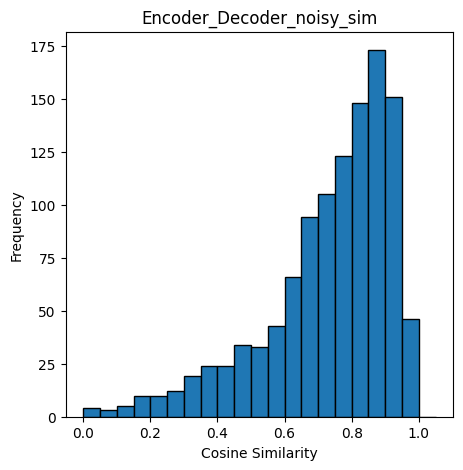

In [126]:
plot(sim_vec2, "Encoder_Decoder_noisy_sim")